In [8]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
#import data
filename1 = '/Users/cgirabawe/Documents/OneDrive/DoD_Backup/BackUp_Data/allresults4f_tmp.csv'
df = pd.read_csv(filename1)
filename2 = '/Users/cgirabawe/Documents/OneDrive/DoD_Backup/BackUp_Data/datatbl.csv'
data = pd.read_csv(filename2)
gaps = df[['n10','n1f','n20','n2f']].min(axis = 1)
gaps = pd.DataFrame(gaps, columns = ['d'])
cols = data.columns
data = [data.c0,data.cf,data.v0,data.vf,data.expectedvf,data.expectedcf,data.deviation,gaps.d,df.Medium]
data = pd.DataFrame(data).T
logd = pd.Series(np.round(map(lambda x:np.log10(x+0.1), data.d)))

logd[logd == 0] = 1
logd[(logd == 2) & (data.Medium != 'Air+2%')] = 1
#logd[df.ExperimentID == 6] = 1



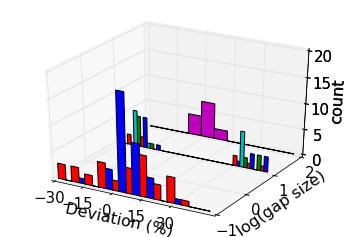

In [10]:
#generate plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#colors dict
clrs = {'0.20%':'c','0.60%':'g','2%':'red','4%':'blue','Air+2%':'m'}
mindev = int(np.floor(data.deviation.min()))
maxdev = int(np.ceil(data.deviation.max()))
step = int((maxdev-mindev)/10)
bins = np.array(range(mindev,maxdev,step))
for ld in sorted(pd.unique(logd)):
    width = 0
    tmp = data[logd == ld]
    for m in pd.unique(tmp.Medium):
        tmp1 = tmp[tmp.Medium == m]

        #print tmp1.head(10)
        xy = np.histogram(tmp1.deviation.values,bins)
        ys = xy[0]
        xs = xy[1]+width
        ax.bar(xs[:-1]+step, ys, zs=[ld]*len(xs), zdir = 'y', color=[clrs[m]]*len(xs),
               width = np.ceil((xs[1:]-xs[:-1])[0]/float(len(pd.unique(tmp.Medium)))))
        #print ld, clrs[m], (xs[1:]-xs[:-1])[0]/len(pd.unique(tmp.Medium))
        width += (xs[1:]-xs[:-1])[0]/float(len(pd.unique(tmp.Medium)))
ax.set_xlabel('Deviation (%)', fontsize = 16)
ax.set_ylabel('log(gap size)', fontsize = 16)
ax.set_zlabel('count', fontsize = 16)

plt.yticks((-1,0,1,2))
plt.xticks((-30,-15,0,15,30))
#ax.set_zticks((0,4,8,12))
#ax.set_zticklabels((0,4,8,12))
#plt.zticks((0,4,8,12))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

###### Observations from figure 1:
1. Touching drops reach expected equilibrium concentration while non-touching do
2. The surfactant is irrelavant
3. The type of medium around drops matter

###### What to do next?
1. Look at kinetics for different surfactant concentrations at all three spacing: generate plots and fits to extract the time constant
2. Plot time constants (from (1)) as function of gap and surfactant concentration

In [11]:
import string
from scipy.optimize import curve_fit
print pd.unique(df[(logd == 1) & (data.Medium == '4%')]['ExperimentID'])
d1 = df[(logd == 1) & (data.Medium == '4%')]
d1 = d1[d1.ExperimentID == 9]
print d1.shape
# read in files
kinetics1 = {}
for i, path in zip(d1.ID, d1.path):
    #path = string.replace(path,'MIS2','MIS3')
    filename = '/Volumes/K1000Drive/THD10168'+string.replace(path,'\\','/')[2:]
    ndata = pd.read_csv(filename)
    kinetics1[i] = (filename,ndata)



[8 9]
(13, 22)


IOError: File /Volumes/K1000Drive/THD10168/BackUp_Data/MIS3/20150321/transformed/drop_00_01_concentration.csv does not exist

In [12]:
n = 0
def func(x, a, T, x0, d):
    #return a*np.exp(-(x-x0)/T)+d
    return a-(x-x0)/T

ndata = kinetics1[kinetics1.keys()[n]][1]
x = ndata.index.values*25*60
y = ndata[ndata.keys()[1]].values
try:
    popt, pcov = curve_fit(func, x[0:], y[0:], p0=(.2, 1e5, -0, 0.1))
    yfit = func(x, *popt)
    plt.plot(x,yfit)
except:
    print "Unfitted" 
plt.plot(x, y, 'ko')
plt.show()
print kinetics1.keys()[n]
print 'Time constant:', popt[1]/3600

IndexError: list index out of range

In [13]:
taus = pd.read_csv('/Users/cgirabawe/Documents/OneDrive/DoD_Backup/BackUp_Data/dataTimeCharacteristics.csv')
extdata = data
extdata['ID'] = df.ID
extdata.index = df.ID
taus.index = taus.ID
taus = pd.concat([taus, extdata[['deviation','Medium','d','ID']]], axis=1, join_axes=[taus.index])

taus['logTau'] = map(lambda x:np.log10(x), taus.Tau)

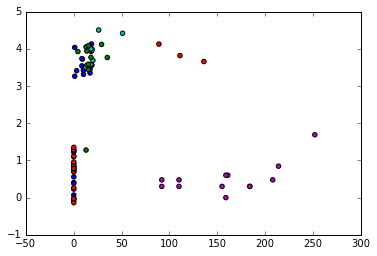

In [14]:
plt.scatter(taus.d,taus.logTau,
            c = map(lambda x:clrs[x],taus.Medium.values))
plt.show()

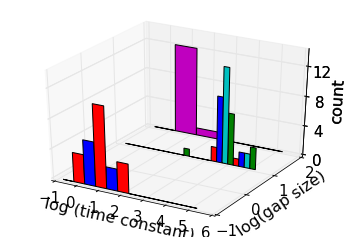

In [15]:
#generate plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#colors dict
clrs = {'0.20%':'c','0.60%':'g','2%':'red','4%':'blue','Air+2%':'m'}
mindev = int(np.floor(taus.logTau.min()))
maxdev = int(np.ceil(taus.logTau.max()))
step = (maxdev-mindev)/20.
bins = np.array(range(mindev*10,maxdev*10,int(step*10)))/10.
bins = np.arange(-1,6,1)
for ld in sorted(pd.unique(taus.logd)):
    width = 0
    tmp = taus[taus.logd == ld]
    for m in pd.unique(tmp.Medium):
        tmp1 = tmp[tmp.Medium == m]

        #print tmp1.head(10)
        xy = np.histogram(tmp1.logTau.values,bins)
        ys = xy[0]
        xs = xy[1]+width
        ax.bar(xs[:-1]+step, ys, zs=[ld]*len(xs), zdir = 'y', color=[clrs[m]]*len(xs),
               width = (xs[1:]-xs[:-1])[0]/float(len(pd.unique(tmp.Medium))))
        #print ld, clrs[m], 1/float(len(pd.unique(tmp.Medium))), width
        width += (xs[1:]-xs[:-1])[0]/float(len(pd.unique(tmp.Medium)))
ax.set_xlabel('log (time constant)', fontsize = 16)
ax.set_ylabel('log(gap size)', fontsize = 16)
ax.set_zlabel('count', fontsize = 16)
plt.yticks((-1,0,1,2))
ax.set_zticks((0,4,8,12))
ax.set_zticklabels((0,4,8,12))
#plt.zticks((0,4,8,12))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

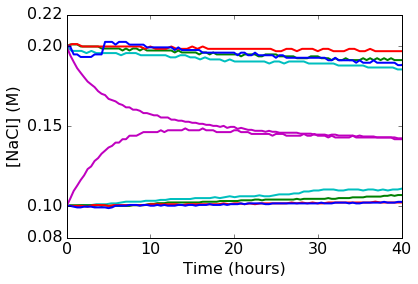

In [17]:
#plot kinetics
import pandas as pd
import matplotlib.pyplot as plt
kinedata = pd.read_csv('/Users/cgirabawe/Documents/OneDrive/DoD_Backup/BackUp_Data/kinetics_4d.csv')
clrs = {'0.2%': 'c', '0.6%': 'g', '2.0%': 'red', '4.0%': 'blue', 'Air+2%': 'm'}
for m in pd.unique(kinedata.Medium):
    for cc in pd.unique(kinedata.c0):
        tmp = kinedata[(kinedata.Medium == m) & (kinedata.c0 == cc)]
        plt.plot(tmp['Time (hrs)'],tmp['C [M]'],
                color = clrs[tmp.Medium[tmp.Medium.index[0]]],
                linewidth = 2,
                label = 'line')

plt.xlim(0, 40)

plt.xlabel('Time (hours)', fontsize = 16)
plt.ylabel('[NaCl] (M)', fontsize = 16)
plt.yticks((0.08, 0.1,0.15,0.2,0.22))
plt.xticks((0,10,20,30,40))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

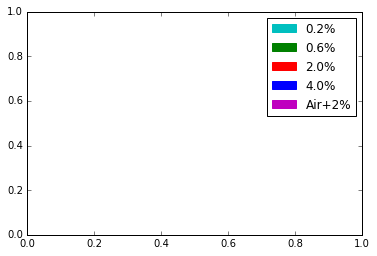

In [18]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

cpatch = mpatches.Patch(color='c', label='0.2%')
gpatch = mpatches.Patch(color='g', label='0.6%')
rpatch = mpatches.Patch(color='r', label='2.0%')
bpatch = mpatches.Patch(color='b', label='4.0%')
mpatch = mpatches.Patch(color='m', label='Air+2%')
plt.legend(handles=[cpatch,gpatch,rpatch,bpatch,mpatch])
plt.show()